In [1]:
import pandas as pd
import numpy as np
import ydata_profiling
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import json

import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# data set load
DATA_PATH = '../data/'

train_df = pd.read_csv(DATA_PATH+'train_data.csv', dtype=dtype, parse_dates=['Timestamp'])
test_df = pd.read_csv(DATA_PATH+'test_data.csv', dtype=dtype, parse_dates=['Timestamp'])

df = pd.concat([train_df, test_df])
df = df.drop(df[df['answerCode']== -1].index) # answerCode = -1 는 예측해야하는 값이므로 제외

CPU times: user 3.29 s, sys: 360 ms, total: 3.65 s
Wall time: 3.66 s


# Data OverView

+ `userID` 사용자의 고유 번호입니다. 총 7,442명의 학생이 있습니다.   
+ `assessmentItemID` 사용자가 푼 문항의 일련 번호입니다.   
+ `testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
+ `answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
+ `Timestamp` 사용자가 문항을 푼 시간 정보입니다.   
+ `KnowledgeTag` 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.   


## ydata_profiling

In [3]:
profile = df.profile_report()
profile

In [4]:
profile.to_widgets()

In [5]:
profile.to_file(output_file="test.html") # html

# EDA

In [3]:
# 문제를 푸는데 걸린 시간 구하기 
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff
df['elapsed'] = df['elapsed'].shift(-1, axis=0)

In [4]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0
...,...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4721258.0
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,18.0
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,21.0
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,89.0


## 같은 문제를 여러번 풀면 정답률이 올라갈까? 

In [42]:
# userid와 assessmentItemID 기준으로 그룹화한다.
grouped = df.groupby(['userID', 'assessmentItemID'])

#각 그룹별로 동일 문제를 몇 번 푸는지를 계산하고, 이를 맵핑할 딕셔너리를 만든다. ex) {(0, 'A020172001'): 1, ...}
counts_dict = grouped.size().to_dict()

# counts_dict를 이용하여 assessmentItemID별로 푼 문제 수를 맵핑한다.
df['#ofsameSolved'] = df.set_index(['userID', 'assessmentItemID']).index.map(counts_dict)

In [10]:
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,#ofSolved,#ofsameSolved
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0,1,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0,1,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0,1,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,1,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0,1,1


In [13]:
df['#ofsameSolved'].unique()

array([1, 2, 3])

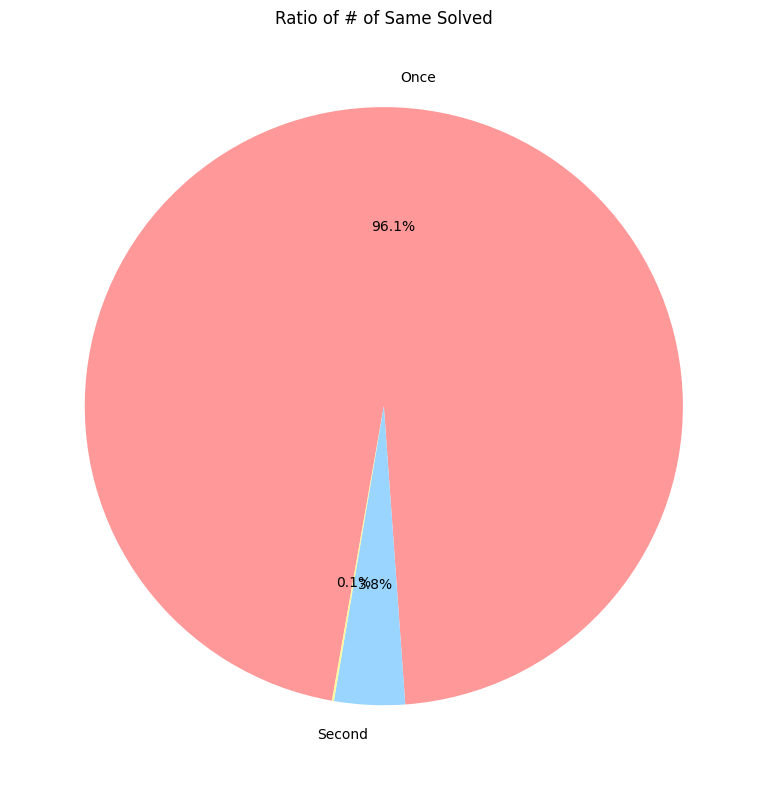

In [25]:
# 시각화
plt.figure(figsize=(8,8))
colors = ['#ff9999', '#99d5ff', '#fff799']

labels = ['Once', 'Second', '']
ratio = df['#ofsameSolved'].value_counts()

plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors)
plt.title('Ratio of # of Same Solved')


plt.tight_layout()
plt.show()

약 96% 정도 동일한 문제를 풀지 않았고, 4% 정도만 동일한 문제를 두번이상 풀었다.

In [52]:
# 동일문제를 3번 푼 데이터는 0.1% 이므로 분석의 용이성을 위해 2번 푼 데이터로 만 진행한다.
df_1 = df[df['#ofsameSolved']==2]

df_1 = df_1.sort_values(by=['userID', 'assessmentItemID', 'Timestamp'], ascending=[True, True, True])
df_1 = df_1.reset_index(drop=True)
df_1

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,#ofsameSolved
0,1,A040155001,A040000155,1,2020-06-21 22:57:14,2111,41.0,2
1,1,A040155001,A040000155,1,2020-08-17 09:56:27,2111,39.0,2
2,1,A040155002,A040000155,1,2020-06-21 22:57:55,2111,38.0,2
3,1,A040155002,A040000155,1,2020-08-17 09:57:06,2111,57.0,2
4,1,A040155003,A040000155,0,2020-06-21 22:58:33,2111,16.0,2
...,...,...,...,...,...,...,...,...
96301,7329,A040198002,A040000198,1,2020-10-12 12:08:53,2133,9.0,2
96302,7329,A040198003,A040000198,1,2020-01-02 12:50:56,2133,8.0,2
96303,7329,A040198003,A040000198,1,2020-10-12 12:09:02,2133,6.0,2
96304,7329,A040198004,A040000198,1,2020-01-02 12:51:04,2133,227150.0,2


In [53]:
# 동일한 문제를 처움 풀었을 때의 정답률
count_answer_first = df_1.iloc[::2]['answerCode'].eq(1).sum()
answer_rate_first = count_answer_first / (len(df_1)//2)

# 동일한 문제를 두번쨰 풀었을 때의 정답률
count_answer_second = df_1.iloc[1::2]['answerCode'].eq(1).sum()
answer_rate_second = count_answer_second / (len(df_1)//2)

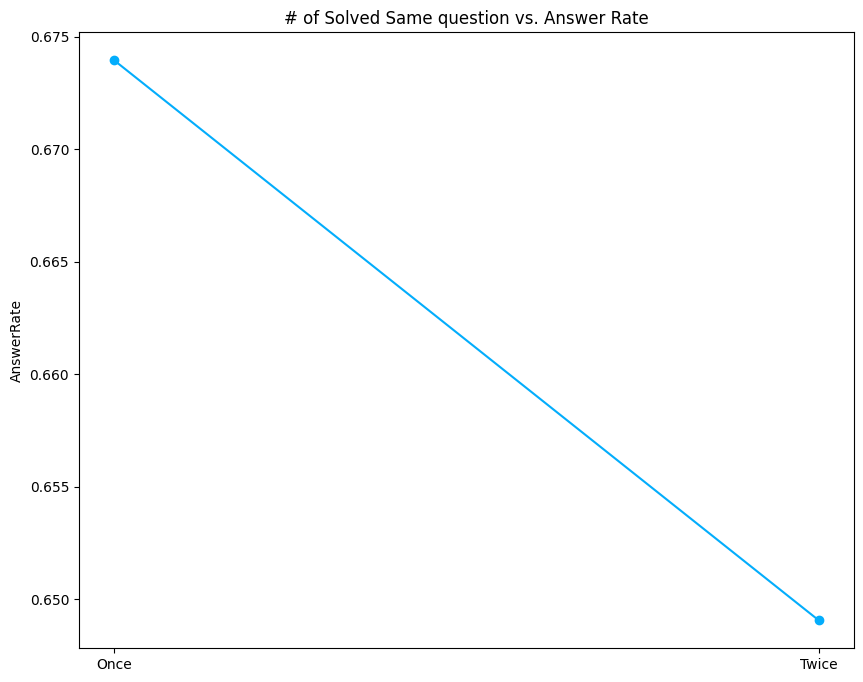

In [67]:
plt.figure(figsize=(10,8))
plt.plot([0,1],[answer_rate_first, answer_rate_second], color='#03adfc',  marker='o')
plt.xticks([0,1], labels=['Once', 'Twice'])
plt.ylabel('AnswerRate')
plt.title('# of Solved Same question vs. Answer Rate')
plt.show()

## Timestamp에 따른 정답률 비교

<AxesSubplot: xlabel='Timestamp', ylabel='Count'>

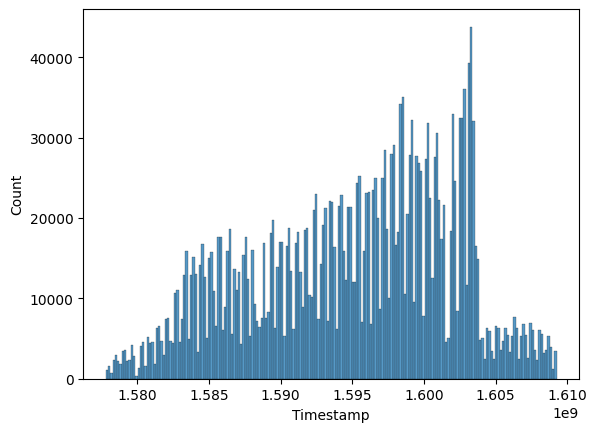

In [68]:
sns.histplot(df.Timestamp.astype(int) / 10**9)

In [69]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,#ofsameSolved
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0,1
...,...,...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4721258.0,1
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,18.0,1
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,21.0,1
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,89.0,1


In [73]:
df_1 = df.copy()

# 연, 월, 일, 시간 나누기
df_1['month'] = df_1['Timestamp'].dt.strftime('%m')
df_1['day'] = df_1['Timestamp'].dt.strftime('%d')
df_1['hour'] = df_1['Timestamp'].dt.strftime('%H')

# 각각으로 그룹화
agg_on_month = df_1.groupby(["month"]).agg({"answerCode": "mean"})
agg_on_hour = df_1.groupby(["hour"]).agg({"answerCode": "mean"})
agg_on_day = df_1.groupby(["day"]).agg({"answerCode": "mean"})

<AxesSubplot: xlabel='day'>

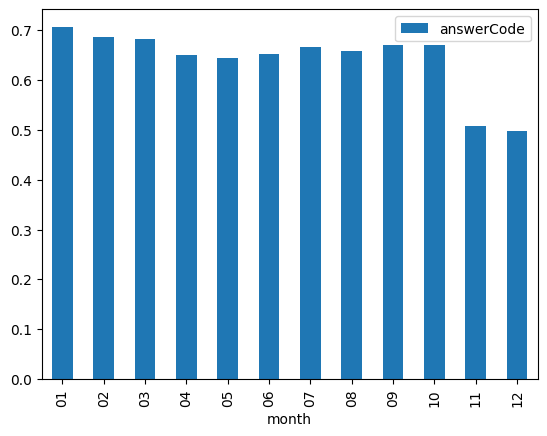

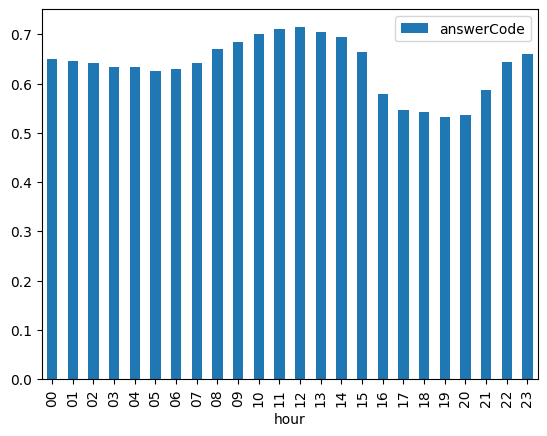

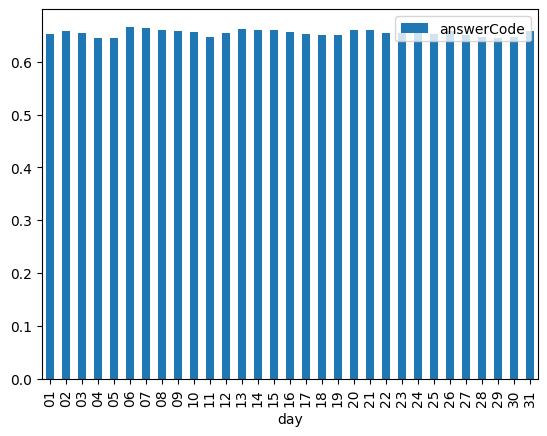

In [74]:
agg_on_month.plot.bar()
agg_on_hour.plot.bar()
agg_on_day.plot.bar()

## 문제 번호에 따른 난이도 

In [ ]:
df_1 = df.copy()

df_1['item'] = df_1['assessmentItemID'].apply(lambda x: x[7:]) # assessmentItemID의 뒤에 3자리를 의미 -> 각 시험지 별로 문제번호 
# item 열을 int16으로 변경 
df_1["item"] = df_1["item"].astype("int16")

In [113]:
# test 별로 그룹화 한뒤 각 test 별로 마지막 문항을 나타내는 last_prob_no 피쳐 생성
tmp = df_1.groupby(["testId"]).agg({"item": "max"})
tmp.rename(columns={"item": "last_prob_no"}, inplace=True)

# 기존의 DF와 merge 하여 각각의 시험지의 마지막 문항을 나타내는 피쳐 추가
tmp_df = df_1.copy()
tmp_df = pd.merge(tmp_df, tmp, on="testId", how="left")

# 마지막 문제와 가까운 정도를 계산 
tmp_df["last_prob"] = tmp_df["item"] / tmp_df["last_prob_no"]
tmp_df = tmp_df.drop("last_prob_no", axis=1)
tmp_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,#ofsameSolved,item,last_prob_no,last_prob
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0,1,1,7,0.142857
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0,1,2,7,0.285714
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0,1,3,7,0.428571
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,1,4,7,0.571429
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0,1,5,7,0.714286
...,...,...,...,...,...,...,...,...,...,...,...
2525207,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4721258.0,1,6,6,1.000000
2525208,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,18.0,1,1,5,0.200000
2525209,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,21.0,1,2,5,0.400000
2525210,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,89.0,1,3,5,0.600000


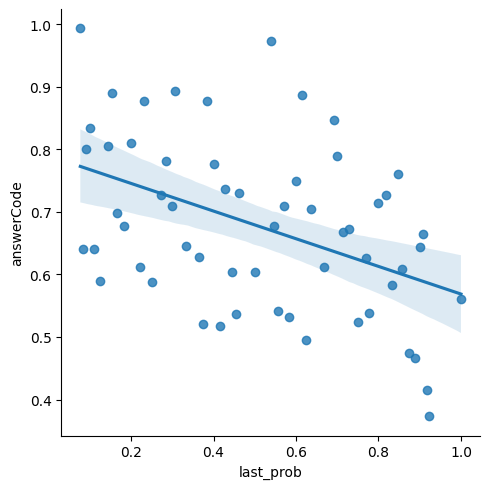

In [114]:
last_prob_group = tmp_df.groupby("last_prob").agg({"answerCode": "mean"}).reset_index()
sns.lmplot(x="last_prob", y="answerCode", data=last_prob_group)
plt.title('How close the problem is to the end vs. Answer Rate')
plt.show()

last_prob는 해당 문제가 그 시험지의 마지막 문항에 가까운 정도를 나타내는 feature 이다. </br></br>
마지막 문제면 1, 마지막 문제에서 멀어질 수록 0에 가까워진다. </br></br>
해당 그래프에서 알 수 있듯 마지막 문제와 가까워 질수록 정답률이 낮아짐을 알 수 있었다.

## 그래서 우리가 예측해야할 문제의 대부분이 시험지의 마지막 문제인지를 확인

In [ ]:
test_df_1 = pd.read_csv('/opt/ml/input/data/test_data.csv')

# test_df 에서도 last_prob feature 생성
test_df_1['item'] = test_df_1['assessmentItemID'].apply(lambda x: x[7:]) # assessmentItemID의 뒤에 3자리를 의미 -> 각 시험지 별로 문제번호 

test_df_1["item"] = test_df_1["item"].astype("int16")

tmp = test_df_1.groupby(["testId"]).agg({"item": "max"})
tmp.rename(columns={"item": "last_prob_no"}, inplace=True)

tmp_df = test_df_1.copy()
tmp_df = pd.merge(tmp_df, tmp, on="testId", how="left")

tmp_df["last_prob"] = tmp_df["item"] / tmp_df["last_prob_no"]
tmp_df = tmp_df.drop("last_prob_no", axis=1)

In [ ]:
tmp_df[tmp_df['answerCode'] == -1].last_prob.plot.hist()
plt.title('How close the predict is to the end')
plt.show()

대부분의 예측해야할 문제가 시험지의 마지막임을 알 수 있었다.